In [1]:
import numpy as np
import pandas as pd
import emoji
import re
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import textblob.exceptions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from deep_translator import GoogleTranslator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv
import time
import tensorflow as tf
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
def remove_enter(val):
    """menghilangkan \n atau enter"""
    return ' '.join(val.split())

def remove_emoji():
    """menghilangkan emoji"""
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

begone_emoji = remove_emoji()

def remove_three_same_char(value):
    """menghilangkan repitisi 3 karakter berurutan seperti gooooool"""
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", value)

def preprocessing_data(val):
    """
    lower huruf, menghilangkan hyperlink, unicode, RT, menghilangkan titik koma ganda,
    menghilangkan enter dan emoji.
    """
    result = val.lower().strip()
    result = remove_enter(result)
    result = re.sub(r'(@|https?)\S+|#[A-Za-z0-9_]+', '', result).replace("&amp;", "dan")
    result = re.sub(r'RT[\s]+','',result)
    result = re.sub('[^.,a-zA-Z0-9 \n\.]', '', result)
    # result = re.sub(r'\d', '', result)
    # result = re.sub(r'[^\w\s]', ' ', result)
    result = re.sub(r'\.+', " . ", result)
    result = re.sub(r'\,+', " , ", result)
    result = remove_three_same_char(result)
    result = begone_emoji.sub(repl='', string=result)
    return result

def final_remove(val):
    """
   fungsi ini digunakan untuk melakukan preprocessing akhir yaitu menghilangkan titk, koma dan karakter selain alfabet.
   setelah bersih akan dilakukan remove stopword dan stemming
    """
    result = re.sub(r'[^\w\s]', ' ', val)
    result = re.sub(r'\d', '', result)
    result = convertSlangWord(result)
    result = remove_stopword_stemming(result)
    return result

factory = StopWordRemoverFactory()
stopwords_id = factory.get_stop_words()
stopword_id = factory.create_stop_word_remover()
stemmer = StemmerFactory().create_stemmer()

def remove_stopword_stemming(val):
    """menghilangkan stopword dan mengubah kata menjadi kata dasar bahasa indonesia"""
    removed = stopword_id.remove(val)
    removed = stemmer.stem(removed)
    return removed

def polarity_decider(val):
    """melihat polaritas menggunakan TextBlob"""
    analize = TextBlob(val)
    processed = analize.sentiment
    if processed.polarity > 0:
        sentimen = 1
    elif processed.polarity < 0:
        sentimen = -1
    else:
        sentimen = 0
    return sentimen

eng_stemmer = PorterStemmer()
def eng_final_remove(val):
    """melakukan preprocessing akhir pada teks english yaitu menghilangkan karakter non alfabet,
    remove stopword, dan stemming"""
    remove_non_char = re.sub(r'[^\w\s]', ' ', val.lower())
    result = re.sub(r'\d', '', remove_non_char)
    stopwords_english = stopwords.words('english')
    tokens = word_tokenize(result)
    remove_sw = [word for word in tokens if not word in stopwords_english]
    stemming_en = [eng_stemmer.stem(word) for word in remove_sw]
    return  ' '.join(stemming_en)

def translate(value, src = 'id', target = 'en'):
    """ menerjemahkan bahasa indonesia ke inggris secara default"""
    result = GoogleTranslator(source=src, target=target).translate(value)
    return result

def vader_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        value = 1
    elif sentiment_dict['compound'] <= - 0.05 :
        value = -1
    else :
        value = 0
    return value

def convertSlangWord(value):
    kamus = eval(open("combined_slang_words.txt").read())
    pattern = re.compile(r"\b(%s)\b" % "|".join(kamus))
    converted = pattern.sub(lambda word: kamus.get(word.group()), value)
    # clear = re.sub(r'[^\w\s]', ' ', converted)
    return converted

In [ ]:
from langdetect import detect
text = df[0][0]
cleaned = preprocessing_data(text)
test = detect(cleaned)
print(test)
print(cleaned)


In [ ]:
def cleaning(open_file_dir: str, save_file_dir: str):
    error_bucket = []
    start = time.time()
    with open(open_file_dir) as csv_data:
        load_data = list(csv.reader(csv_data, delimiter=';'))
        dictionary = {}
        list_of_dictionary = []
        for index,item in enumerate(load_data[1:]):
            # print((start_row+index))
            # print(item[0])
            # break
            if index%500 == 0:
                # prevent API limitation around 550-800 at batch request
                time.sleep(20)
            try:
                translate_en = translate(preprocessing_data(item[0]))
                origin_id = preprocessing_data(item[0])
                # sentiment, translated = polarity_decider(preprocessing_data(item[0]))
                dictionary = {
                    'origin_text_id' : origin_id,
                    'text_id': final_remove(origin_id),
                    'origin_text_en': translate_en,
                    # 'text_en': eng_final_remove(preprocessing_data(translated)),
                    'text_en': eng_final_remove(translate_en),
                    'label_vader' : vader_sentiment(translate_en),
                    # 'label_textblob':sentiment
                }
                list_of_dictionary.append(dictionary)
            except:
                # error_bucket.append(index)
                continue
    # print(len(list_of_dictionary))
    end = time.time()
    delta = end - start
    # print(f"time execute : {delta} seconds")
    df_clean = pd.DataFrame(list_of_dictionary)
    df_clean.to_csv(save_file_dir, index=False, sep=';')
    return_message ={
        "time execute": f"{delta} seconds",
        "saved file" : save_file_dir
    }
    return return_message

In [9]:
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
cores = cpu_count()-1
results = []
with open('data oktober-des 2022 etilang tanpa lang dan etle.csv', encoding='utf-8') as csv_data:
    load_data = list(csv.reader(csv_data, delimiter=';'))
    load_data.pop(0)
    chunks = np.array_split(load_data, cores)


def worker(raw: list) -> list:
    processed_bucket = []
    for data in raw:
        temp_dict = {
            'text_id': final_remove(preprocessing_data(str(data)))
        }
        processed_bucket.append(temp_dict)

    return processed_bucket
start = time.time()
with ThreadPoolExecutor(cores) as executor:
    for result in executor.map(worker, chunks):
        results.extend(result)
end = time.time()
delta = end-start
print(f"time execute with multithreading : {delta} seconds")
df_clean = pd.DataFrame(results)
df_clean.to_csv('fix_with_slang_multithreading.csv', index=False, sep=';')


time execute with multithreading : 892.9202611446381 seconds


In [3]:
error_bucket = []
start = time.time()





with open('dataset_final_vader.csv', encoding='utf-8') as csv_data:
    load_data = list(csv.reader(csv_data, delimiter=';'))
    dictionary = {}
    list_of_dictionary = []
    start_row = 1
    for index,item in enumerate(load_data[start_row:]):
        # print((start_row+index))
        # if index%500 == 0:
        #     time.sleep(30)
        # print(item[0])
        # break
        try:
            # translate_en = translate(preprocessing_data(item[0]))
            origin_id = preprocessing_data(item[0])
            # sentiment, translated = polarity_decider(preprocessing_data(item[0]))
            dictionary = {
                # 'origin_text_id' : origin_id,
                'text_id': final_remove(origin_id)
                # 'origin_text_en': translate_en,
                # 'text_en': eng_final_remove(preprocessing_data(translated)),
                # 'text_en': eng_final_remove(translate_en),
                # 'label_vader' : vader_sentiment(translate_en),
                # 'label_textblob':sentiment
            }
            list_of_dictionary.append(dictionary)
        except:
            error_bucket.append(index)
# print(len(list_of_dictionary))
end = time.time()
delta = end- start
print(f"time execute : {delta} seconds")

df_clean = pd.DataFrame(list_of_dictionary)
df_clean.to_csv('fix_with_slang.csv', index=False, sep=';')

time execute : 700.7128784656525 seconds


In [12]:
list_of_dictionary

[{'origin_text_id': 'kembangkan etle , 7 polda dapat penghargaan di rakernis fungsi gakkum',
  'text_id': 'kembang etle polda dapat harga di rakernis fungsi gakkum',
  'origin_text_en': 'develop etle , 7 regional police won awards at the Gakum function meeting',
  'text_en': 'develop etl region polic award gakum function meet',
  'label_vader': 1},
 {'origin_text_id': 'sosialisasi etle dan app smart city',
  'text_id': 'sosialisasi etle dan app smart city',
  'origin_text_en': 'etle socialization and smart city app',
  'text_en': 'etl social smart citi app',
  'label_vader': 1},
 {'origin_text_id': 'berita populer kumparanoto , selasa 1312 detail vespa batik seharga rp 77 juta , cara kerja dan jenis pelanggaran tilang etle mobile .',
  'text_id': 'berita populer kumparanoto selasa detail vespa batik harga rp juta cara kerja dan jenis langgar tilang etle mobile',
  'origin_text_en': 'Kupang Popular News, Tuesday 1312 details Vespa batik worth IDR 77 million, how it works and types of Et

In [6]:
with open('dataset_final_vader.csv') as csv_data:
    load_data = list(csv.reader(csv_data, delimiter=';'))
    dictionary = {}
    list_of_dictionary = []
    for index,item in enumerate(load_data[1:]):
        try:



In [3]:
df_try = pd.read_csv('dataset_final_vader.csv', sep=';')
df_try.head()

,origin_text_id,text_id,origin_text_en,text_en,label_vader
0,"kembangkan etle , 7 polda dapat penghargaan di...",kembang etle polda dapat harga di rakernis fun...,"develop etle , 7 regional police won awards at...",develop etl region polic award gakum function ...,1
1,sosialisasi etle dan app smart city,sosialisasi etle dan app smart city,etle socialization and smart city app,etl social smart citi app,1
2,"berita populer kumparanoto , selasa 1312 detai...",berita populer kumparanoto selasa detail vespa...,"Kupang Popular News, Tuesday 1312 details Vesp...",kupang popular news tuesday detail vespa batik...,1
3,"mimin kasih info ya gaes , kita mau uji coba e...",mimin kasih info ya gaes kita mau uji coba etl...,"Mimin, give me some info, guys, we want to try...",mimin give info guy want tri etl tangerang cit...,-1
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung laksana teg...,Badung Police traffic personnel carry out a hu...,badung polic traffic personnel carri human war...,-1


In [11]:
df_try['label_textblob'] = df_try['origin_text_en'].apply(lambda x: polarity_decider(x))

In [12]:
df_try.head()

,origin_text_id,text_id,origin_text_en,text_en,label_vader,label_textblob
0,"kembangkan etle , 7 polda dapat penghargaan di...",kembang etle polda dapat harga di rakernis fun...,"develop etle , 7 regional police won awards at...",develop etl region polic award gakum function ...,1,0
1,sosialisasi etle dan app smart city,sosialisasi etle dan app smart city,etle socialization and smart city app,etl social smart citi app,1,1
2,"berita populer kumparanoto , selasa 1312 detai...",berita populer kumparanoto selasa detail vespa...,"Kupang Popular News, Tuesday 1312 details Vesp...",kupang popular news tuesday detail vespa batik...,1,1
3,"mimin kasih info ya gaes , kita mau uji coba e...",mimin kasih info ya gaes kita mau uji coba etl...,"Mimin, give me some info, guys, we want to try...",mimin give info guy want tri etl tangerang cit...,-1,1
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung laksana teg...,Badung Police traffic personnel carry out a hu...,badung polic traffic personnel carri human war...,-1,0


3816    1
2711    1
1094    1
Name: label_textblob, dtype: int64


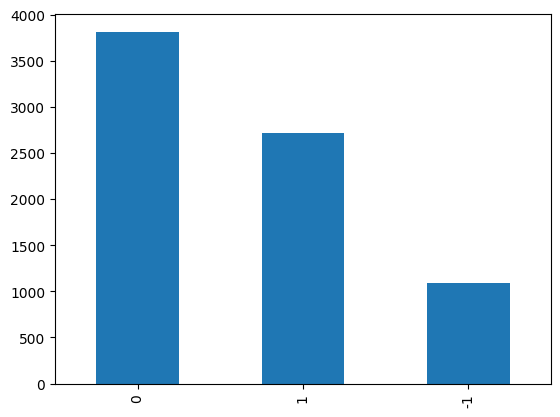

In [13]:
labels = df_try['label_textblob']
labels_count = labels.value_counts()
labels_count.plot(kind='bar')
print(labels_count.value_counts())

In [14]:
df_try.to_csv('dataset_vader_textblob.csv',index=False, sep=';')